In [258]:
import pandas as pd
import numpy as np 
from numpy import random
import nltk, re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Dropout, Bidirectional

from sentence_transformers import SentenceTransformer

In [259]:
df = pd.read_csv('stock_data.csv')

In [260]:
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

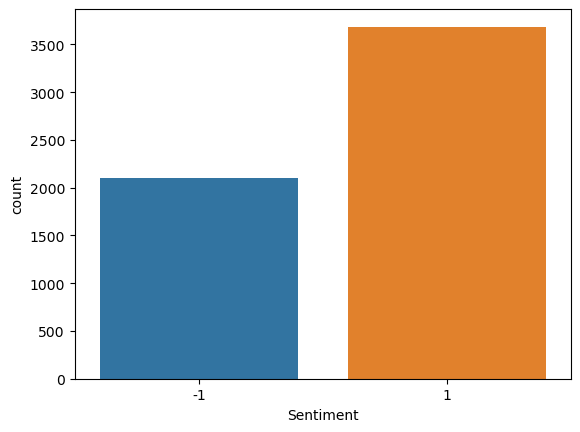

In [261]:
sns.countplot(x ='Sentiment', data = df)

In [262]:
ix = list(range(df.shape[0]))
ix = random.permutation(ix)

In [263]:
%%time
div = int(df.shape[0] * 0.7)
train_df = df.iloc[ix[0:div]]
corpus_train = train_df[['Text']]

test_df = df.iloc[ix[div:]]
corpus_test = test_df[['Text']]

CPU times: user 6.81 ms, sys: 108 µs, total: 6.92 ms
Wall time: 6.14 ms


In [264]:
print(train_df.shape)
print(corpus_train.shape)

(4053, 2)
(4053, 1)


In [265]:
def get_wordlist(corpus1):
    words = []
    for phrase in corpus1:
        for word in phrase.split():
            words.append(word)       
             
    words.sort()
    return set(words)

In [268]:
word_set_train = get_wordlist(corpus_train['Text'].values)
word_set_test = get_wordlist(corpus_test['Text'].values)

In [270]:
def get_dicts(word_set):
    word_to_index = {}
    for i, word in enumerate(word_set):
        word_to_index[word] = i  
        
    index_to_word = {index:word for (word, index) in word_to_index.items()}
    
    return word_to_index, index_to_word

In [271]:
word_to_index_train, index_to_word_train = get_dicts(word_set_train)
word_to_index_test, index_to_word_test = get_dicts(word_set_test)

In [272]:
def token(corpus, word_to_index):
    tokenized_list = []
    
    for phrase in corpus:
        tokenized_format = []
        for word in phrase.split():
            index = word_to_index[word]
            tokenized_format.append(index)
            
        tokenized_list.append(tokenized_format)
        
    return np.array(tokenized_list, dtype='object')

In [277]:
X_train = token(corpus_train['Text'].values, word_to_index_train)
X_test = token(corpus_test['Text'].values, word_to_index_test)

In [278]:
maxlen = 30
X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')

In [279]:
y_train = train_df.iloc[:,-1].values

In [280]:
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))

In [281]:
vocabulary_size = len(word_to_index_train) + 1
embedding_size=30

In [282]:
vocabulary_size = len(word_to_index_train) + 1
embedding_size=30

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, trainable=True))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 30)          419610    
                                                                 
 bidirectional_52 (Bidirecti  (None, 128)              48640     
 onal)                                                           
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 2)                 258       
                                                                 
Total params: 468,508
Trainable params: 468,508
Non-trainable params: 0
_________________________________________________________________


In [283]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [284]:
print(X_train.shape)
print(X_train_padded.shape)

(4053,)
(4053, 30)


In [285]:
model.fit(X_train_padded, y_train_encoded, batch_size=256, epochs=5 )

Epoch 1/5
16/16 [==============================] - 7s 110ms/step - loss: 0.6660 - accuracy: 0.6373
Epoch 2/5
16/16 [==============================] - 2s 104ms/step - loss: 0.6482 - accuracy: 0.6373
Epoch 3/5
16/16 [==============================] - 2s 103ms/step - loss: 0.6113 - accuracy: 0.6388
Epoch 4/5
16/16 [==============================] - 2s 105ms/step - loss: 0.4399 - accuracy: 0.8058
Epoch 5/5
16/16 [==============================] - 2s 105ms/step - loss: 0.2506 - accuracy: 0.9154


In [286]:
pred = model.predict(X_test_padded)

55/55 [==============================] - 2s 11ms/step


In [304]:
pred

array([[0.0519728 , 0.9480272 ],
       [0.5092736 , 0.49072647],
       [0.00115109, 0.9988489 ],
       ...,
       [0.39447793, 0.6055221 ],
       [0.83075225, 0.16924773],
       [0.01043145, 0.98956853]], dtype=float32)

In [306]:
labels = [-1, 1]
LABELS=[labels[i] for i in pred.argmax(axis=-1)]

In [307]:
#predicted = pd.DataFrame({'Phrase': test_df.iloc[:,0].values, 'Sentiment': LABELS})
predicted = pd.DataFrame({'text': test_df['Text'].values, 'Sentiment': LABELS})

In [308]:
predicted

,text,Sentiment
0,"AAP Gap bottom 437.72, gap top 441.34 and now ...",1
1,WPI - whoopie - that's the stocks nickname,-1
2,AAP Probabilities rising for a test of the 20...,1
3,chear up AAP holics allot of bulls just got bu...,1
4,"ed Monthly Triangle on CSN,.......pdating",1
...,...,...
1733,"NS should start to slide here just like HF, th...",1
1734,Market Wrap Video + Additions to Watch ist in...,1
1735,COVEED FDX 96.50 from 96.85.,1
1736,YHOO 5 min - looking for a nice smooth 20/50MA...,-1


In [309]:
print(classification_report(test_df['Sentiment'], y_pred = predicted['Sentiment'], labels = labels))

              precision    recall  f1-score   support

          -1       0.34      0.38      0.36       636
           1       0.62      0.58      0.60      1102

    accuracy                           0.51      1738
   macro avg       0.48      0.48      0.48      1738
weighted avg       0.52      0.51      0.51      1738



In [310]:
test_df['Text'][0:10]

4396    AAP Gap bottom 437.72, gap top 441.34 and now ...
610            WPI - whoopie - that's the stocks nickname
799     AAP  Probabilities rising for a test of the 20...
3134    chear up AAP holics allot of bulls just got bu...
2422          ed Monthly Triangle on CSN,.......pdating  
4592                       BAC aising My Stop a little...
1642    user: AAP Ok... this action makes no sense. >>...
3857    AAP I can't remember another time I was so hap...
251                                      CVA Over 19.00  
189     GDOT nice bounce from its 50SMA. ooks ready to...
Name: Text, dtype: object